In [1]:
# !pip install langchain
# !pip install langchain_core
# !pip install langchain_ollama
# !pip install langchain_huggingface
# !pip install prompt

In [2]:
from langchain_core.messages import AIMessage, BaseMessage, HumanMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_ollama import ChatOllama

In [ ]:
import getpass
import os

def _set_if_undefined(var: str) -> None:
    if os.environ.get(var):
        return
    os.environ[var] = getpass.getpass(var)


_set_if_undefined("TAVILY_API_KEY")
# _set_if_undefined("FIREWORKS_API_KEY")

### 設定 `llm`

In [4]:
!ollama list

NAME                   ID              SIZE      MODIFIED     
llava:34b              3d2d24f46674    20 GB     7 days ago      
minicpm-v:latest       c92bfad01205    5.5 GB    7 days ago      
deepseek-r1:32b        38056bbcbb2d    19 GB     8 days ago      
gemma3:27b             30ddded7fba6    17 GB     8 days ago      
llama3.2-vision:90b    d2a5e64c56a9    54 GB     9 days ago      
qwq:latest             cc1091b0e276    19 GB     11 days ago     
deepseek-r1:70b        0c1615a8ca32    42 GB     11 days ago     
llama3.3:latest        a6eb4748fd29    42 GB     2 months ago    


In [5]:
llm = ChatOllama(
    model="qwq:latest",
    temperature=0,
    # other params...
)

### 設定 `embeddings` 與 `vector_store`

In [6]:
from langchain_huggingface import HuggingFaceEmbeddings

embeddings = HuggingFaceEmbeddings(model_name="sentence-transformers/all-mpnet-base-v2")

In [7]:
from langchain_core.vectorstores import InMemoryVectorStore

vector_store = InMemoryVectorStore(embeddings)

### 建立資料來源 `doc`

In [8]:
import requests
response = requests.get("https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l")
print(response.status_code)
print(response.text[:100])  # 只顯示部分內容確認是否成功抓取


200
<!DOCTYPE html>
<html lang="dev" data-themeable="true">

<head>
    <meta charset="utf-8">
    <meta


In [9]:
import bs4
from langchain_community.document_loaders import WebBaseLoader

# Only keep post title, headers, and content from the full HTML.
bs4_strainer = bs4.SoupStrainer(id="publish-page")
loader = WebBaseLoader(
    web_paths=("https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l",),
    bs_kwargs={"parse_only": bs4_strainer},
)
docs = loader.load()

assert len(docs) == 1
print(f"Total characters: {len(docs[0].page_content)}")

USER_AGENT environment variable not set, consider setting it to identify your requests.


Total characters: 2941


In [10]:
print(docs[0].page_content[:100])

# 詐騙判斷準則


## 詐騙準則種類一:賭博、博弈
### 關鍵字:娛樂城、百家樂、運彩
**娛樂城**
- 非詐騙類型(label = 0)：
1. 要求推薦平台或代理，沒有誘導之意的貼文。
2


In [11]:
from langchain_text_splitters import RecursiveCharacterTextSplitter

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=500,  # chunk size (characters)
    chunk_overlap=100,  # chunk overlap (characters)
    add_start_index=True,  # track index in original document
)
all_splits = text_splitter.split_documents(docs)

print(f"Split blog post into {len(all_splits)} sub-documents.")

Split blog post into 8 sub-documents.


In [12]:
print(f"原始文章拆分為 {len(all_splits)} 個子文件。")

for i in range(len(all_splits)):
    print(f"\n第{i+1}個子文件預覽:\n{all_splits[i].page_content}")

原始文章拆分為 8 個子文件。

第1個子文件預覽:
# 詐騙判斷準則


## 詐騙準則種類一:賭博、博弈
### 關鍵字:娛樂城、百家樂、運彩
**娛樂城**
- 非詐騙類型(label = 0)：
1. 要求推薦平台或代理，沒有誘導之意的貼文。
2. 抱怨、咒罵娛樂城、百家樂之詐騙詐欺行為的貼文。
3. 分享戰積、知識或自己對於娛樂城百家樂之想法的貼文。
4. 單純詢問有關娛樂城與百家樂的問題，無誘導他人傾向之貼文。
- 詐騙類型(label = 1):
1. 推薦他人平台或代理，並給予不合理之條件，像是免費給錢、註冊金等，判定為詐騙。
2. 剛創立的帳號，並且過多相同的複製文，判定為詐騙。

**百家樂**
基本和上述條件差不多，只是多了專有名詞：救紅，指的是玩家虧錢，找人來代理操作，試圖少虧或盈利。
- 非詐騙類型(label = 0):
1. 單純尋找救紅，可能會提到一些條件，但無欺騙他人之意的貼文
- 詐騙類型(label = 1):
1. 推薦救紅的代理，或自薦，並給予不合理之保證或條件，判定為詐騙。

第2個子文件預覽:
**運彩**
- 非詐騙類型(label = 0):
1. 單純分享運彩賺錢、虧錢、知識，無誘導之意圖的貼文。
2. 單純的運彩分析，無誘導他人加入群組或入金之意圖的貼文。
3. 單純詢問問題，無誘導他人之傾向的貼文。
- 詐騙類型(label = 1):
1. 意圖誘導他人加入群組，或像老師求教的貼文。
2. 過高且不合理的運彩勝率，並有誘使他人入金或加入群組的貼文。
3. 剛創立的帳號，並且過多相同的複製文，判定為詐騙。

第3個子文件預覽:
## 詐騙準則種類二:投資
### 關鍵字:投資、股票、加密貨幣
**投資**
- 非詐騙類型(label = 0):
1. 單純分享投資消息或投資知識的貼文，例如個股投資進場退場、加密貨幣投資進場退場。
2. 單純分享自己投資賺賠的貼文，無誘導加入群組、追蹤IG(不一定)或投資之意圖。
3. 詢問問題，無誘導的意圖之貼文。
- 詐騙類型(label = 1):
1. 有誘導他人進場之意圖的貼文，例如:明天台積電一定跌，趕快進場、**內部消息**...
2. 用不合理或誇大(穩賺不賠、零風險)等字眼誘導他人跟隨進場、加入群組、追蹤IG的貼文。
3. 推薦或自薦老師，誇大獲利以誘使他人跟隨

In [13]:
document_ids = vector_store.add_documents(documents=all_splits)

print(document_ids[:3])

['92c206b5-e9be-4dc4-9680-ae7092682ace', 'e2ac19c2-1ae4-4e24-8be8-ceede0a54c34', 'b1ddfdf1-c005-4321-bfb2-7f92a6523442']


In [14]:
from transformers import pipeline

# 指定模型
qa_pipeline = pipeline(
    "question-answering",
    model="allenai/longformer-base-4096",
    tokenizer="allenai/longformer-base-4096",
    max_length=4096,          # 強制保持模型原始長度
    truncation=True,          # 明確啟用截斷
    doc_stride=128,
    padding="max_length"      # 確保填充到指定長度
)


context = "人工智慧（AI）是計算機科學的一個領域，旨在創造能夠執行需要人類智慧的任務的機器。"
question = "什麼是人工智慧？"

answer = qa_pipeline(question=question, context=context)
print(answer['answer'])

Some weights of LongformerForQuestionAnswering were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Device set to use mps:0
Input ids are automatically padded to be a multiple of `config.attention_window`: 512


是計算機科學的一個領域，


### RAG 方法三:

`query or response` + `tool` + `generate`

In [15]:
from langgraph.graph import MessagesState, StateGraph

graph_builder = StateGraph(MessagesState)

In [16]:
from langchain_core.tools import tool


@tool(response_format="content_and_artifact")
def retrieve(query: str):
    """Retrieve information related to a query."""
    retrieved_docs = vector_store.similarity_search(query, k=2)
    serialized = "\n\n".join(
        (f"Source: {doc.metadata}\n" f"Content: {doc.page_content}")
        for doc in retrieved_docs
    )
    return serialized, retrieved_docs

In [17]:
from langchain_core.messages import SystemMessage
from langgraph.prebuilt import ToolNode


# Step 1: Generate an AIMessage that may include a tool-call to be sent.
def query_or_respond(state: MessagesState):
    """Generate tool call for retrieval or respond."""
    llm_with_tools = llm.bind_tools([retrieve])
    response = llm_with_tools.invoke(state["messages"])
    # MessagesState appends messages to state instead of overwriting
    return {"messages": [response]}


# Step 2: Execute the retrieval.
tools = ToolNode([retrieve])


# Step 3: Generate a response using the retrieved content.
def generate(state: MessagesState):
    """Generate answer."""
    # Get generated ToolMessages
    recent_tool_messages = []
    for message in reversed(state["messages"]):
        if message.type == "tool":
            recent_tool_messages.append(message)
        else:
            break
    tool_messages = recent_tool_messages[::-1]

    # Format into prompt
    docs_content = "\n\n".join(doc.content for doc in tool_messages)
    system_message_content = (
        "你是一個貼文分析師，負責判斷該貼文是否為詐騙，"
        "請將屬於詐騙的貼文標註為 predict = 1，"
        "不屬於詐騙的貼文標註為 predict = 0，"
        "並詳細說明你的判斷依據，"
        "請注意一定要有輸出 'predict = 1' 或是 'predict = 0'"
        "下面會提供一些搜尋到的片段供你做參考使用"
        "\n\n"
        f"{docs_content}"
    )
    conversation_messages = [
        message
        for message in state["messages"]
        if message.type in ("human", "system")
        or (message.type == "ai" and not message.tool_calls)
    ]
    prompt = [SystemMessage(system_message_content)] + conversation_messages

    # Run
    response = llm.invoke(prompt)
    return {"messages": [response]}

In [18]:
from langgraph.graph import END
from langgraph.prebuilt import ToolNode, tools_condition

graph_builder.add_node(query_or_respond)
graph_builder.add_node(tools)
graph_builder.add_node(generate)

graph_builder.set_entry_point("query_or_respond")
graph_builder.add_conditional_edges(
    "query_or_respond",
    tools_condition,
    {END: END, "tools": "tools"},
)
graph_builder.add_edge("tools", "generate")
graph_builder.add_edge("generate", END)

graph = graph_builder.compile()

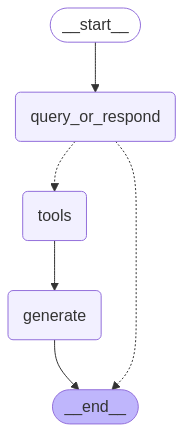

In [19]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
import json
import random
import itertools

categories = ['emotional_dating', 'gamble', 'investment', 'work']
dataset = []

# 讀取所有檔案並合併
for category in categories:
    with open(f"../Datasets_crawler/data_{category}.json", "r", encoding="utf-8") as f:
        data = json.load(f)
        dataset.extend(data)  # 把每個檔案的資料加入 all_data

# 打亂所有資料
random.shuffle(dataset)

In [21]:
output_data = []

In [ ]:
import datetime

timestamp = datetime.datetime.now().strftime("%m%d_%H%M")
output_filename = f"test/output_{timestamp}.json"

with open(output_filename, "w", encoding="utf-8") as f:

    f.write("[\n")

    for count, post in enumerate(dataset, start=1):

        input_message = post['text']

        for step in graph.stream(
            {"messages": [{"role": "user", "content": input_message}]},
            stream_mode="values",
        ):
            step["messages"][-1].pretty_print()

        ai_response = step["messages"][-1].text()

        # 判斷是否有 predict = 1
        if "predict = 1" in ai_response:
            predict_label = 1
        elif "predict = 0" in ai_response:
            predict_label = 0
        else:
            predict_label = None

        print(f"\n🤖判斷結果: {predict_label}\n\n")

        post["predict"] = predict_label

        if count > 1:  # 第一筆資料不加逗號
            f.write(",\n")

        json.dump(post, f, ensure_ascii=False, indent=4)

    # 完成所有處理後，寫入結束括號
    f.write("]\n")

print(f"已將結果輸出至 {output_filename}")

================================ Human Message =================================

徵。女友
我高一15歲
很矮才165
住在新北市泰山區
長的普通
成績中上
女友條件：
希望可以是住在附近的
跟我一樣高
長的漂亮很瘦
高中生


================================== Ai Message ==================================
Tool Calls:
  retrieve (25c8c34f-0335-4615-af90-2e073085371d)
 Call ID: 25c8c34f-0335-4615-af90-2e073085371d
  Args:
    query: 如何在高中阶段健康地发展人际关系及寻找同龄朋友的新北市泰山区资源
================================= Tool Message =================================
Name: retrieve

Source: {'source': 'https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l', 'start_index': 1843}
Content: **高薪兼職**
- 非詐騙類型（label = 0）
1. 一般兼職討論：分享兼職經驗、兼職心得，或單純詢問兼職相關問題。
2. 明確的兼職條件：貼文包含工作地點、工作內容、薪資標準、發薪方式，資訊透明。
- 詐騙類型（label = 1）
1. 誇張的薪資承諾：「在家兼職月入三萬」、「斜槓自由排班穩賺不賠」、「零成本高收入」等不合理描述。
3. 不明兼職內容：只說「輕鬆賺大錢」但沒有具體工作內容的貼文。
4. 缺乏正規應徵管道：沒有公司資訊，只提供個人聯絡方式，如 LINE、WhatsApp。
5. 模板文:「在家兼職做PT還比正職高薪…\n兼職一個月在家就能領50000」
6. 薪資過高

Source: {'source': 'https://hackmd.io/@IizmYTUETE2C0DpZ8K_zUw/HyO0B3Yh1l', 'start_index': 0}
Content: # 詐騙判斷準則


## 詐騙準則種類一:賭博、博弈
### 關鍵字:娛樂城、百家樂、運彩
**娛樂城**
- 非詐騙類型(label = 0)：
1. 要求推薦平台或代理，沒有誘導之意的貼文。
2. 抱怨、咒罵娛樂城、百家樂之詐騙詐欺行為的貼文。
3. 分享戰積、知識或自己對於娛樂城百家樂之想法的貼

In [ ]:
# output_filename = "output.json"
# with open(output_filename, "w", encoding="utf-8") as f:
#     json.dump(output_data, f, ensure_ascii=False, indent=4)

# print(f"已將結果輸出至 {output_filename}")

已將結果輸出至 output.json


### RAG 方法四:

`agent` + `tools`

In [ ]:
# from langgraph.checkpoint.memory import MemorySaver
# from langgraph.prebuilt import create_react_agent

# memory = MemorySaver()
# graph = graph_builder.compile(checkpointer=memory)

# agent_executor = create_react_agent(llm, [retrieve], checkpointer=memory)

In [ ]:
# display(Image(agent_executor.get_graph().draw_mermaid_png()))

In [ ]:
# for i, data in enumerate(dataset):  
#     input_message = data['text']  # 取得當前的輸入訊息
#     config = {"configurable": {"thread_id": str(i+1)}}

#     print(f"--- Conversation {i+1} (Thread ID: {i+1}) ---")
    
#     for step in graph.stream(
#         {"messages": [{"role": "user", "content": input_message}]},
#         stream_mode="values",
#         config=config,
#     ):
#         step["messages"][-1].pretty_print()  # 顯示代理的回應